In [1]:
!pip install gym[toy_text]
!pip install colorama

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 18.3/18.3 MB 51.1 MB/s eta 0:00:00
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


First, we import the needed libraries as below:

In [2]:
import gym
import numpy as np
import matplotlib.pyplot as plt
import random
import pygame
from pygame.locals import *
from IPython.display import clear_output
from time import sleep
import pandas as pd
from scipy.signal import savgol_filter

We installed gym, and now we can load the **game environment** to see the action and state spaces:

Action Space Discrete(6)
State Space Discrete(500)


/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


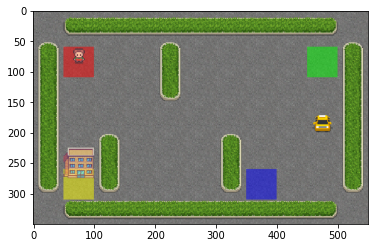

In [3]:
env = gym.make("Taxi-v3").env
print("Action Space {}".format(env.action_space))
print("State Space {}".format(env.observation_space))
state = env.reset()
plt.imshow(env.render(mode = 'rgb_array'))

As we can see, we have an **Action Space** of size 6 and a **State Space** of size 500. The 500 states correspond to a encoding of the taxi's location, the passenger's location, and the destination location, and the 6 actions correspond to:

0 = south,
1 = north,
2 = east,
3 = west,
4 = pickup,
5 = dropoff

# **Part A)** without Reinforcement Learning:

When the Taxi environment is created, there is an initial **Reward table** that's also created, called P. We can think of it like a matrix that has the number of states as rows and number of actions as columns.
This dictionary has the structure:

**{action: [(probability, nextstate, reward, done)]}.**

1) The 0-5 corresponds to the actions.

2) The nextstate is the state we would be in if we take the action at this index of the dict

3) All the movement actions have a -1 reward and the pickup/dropoff actions have -10 reward in this particular state. If we are in a state where the taxi has a passenger and is on top of the right destination, we would see a reward of 20 at the dropoff action.

4) done is used to tell us when we have successfully dropped off a passenger in the right location. 



In [ ]:
env.P[300]

{0: [(1.0, 400, -1, False)],
 1: [(1.0, 200, -1, False)],
 2: [(1.0, 300, -1, False)],
 3: [(1.0, 300, -1, False)],
 4: [(1.0, 300, -10, False)],
 5: [(1.0, 300, -10, False)]}

Since we have our P table for **default rewards** in each state, we can try to have our taxi navigate just using that.



For this purpose, I created an infinite loop which runs until one passenger reaches one destination (when the received reward is 20). 

The env.action_space.sample() method **automatically** selects one **random** action from set of all possible actions.

I store my results in a list called 'frame', which I can later use for **graphic visualizations**.

As the outputs of this function, I retun the frames array, the number of **epochs**, and the number of wrong decisions (**penalties**) the agent took to run the code to later use them for evaluation of this algorithm.

In [ ]:
epochs = 0
penalties, reward = 0, 0
frames = []
state = env.reset()
done = False
while not done:
  action = env.action_space.sample()
  state, reward, done, info = env.step(action)
  if reward == -10:
    penalties += 1
  frames.append({
    'frame': env.render(mode = 'rgb_array'),
    'state': state,
    'action': action,
    'reward': reward})
  epochs += 1

In the below function, I implement a graphic visualization of the above algorithm. In each time step, we can see the state which we are in, the action the agent takes, and the reward it recieves along with its position in our game environment.

In [21]:
def print_frames(frames):
    for i, frame in enumerate(frames):
        clear_output(wait=True)
        plt.imshow(frame['frame'])
        plt.show()
        print(f"Timestep: {i + 1}")
        print(f"State: {frame['state']}")
        print(f"Action: {frame['action']}")
        print(f"Reward: {frame['reward']}")
        sleep(.1)

Testing the above function for one episode:

In [ ]:
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 1874
Penalties incurred: 590


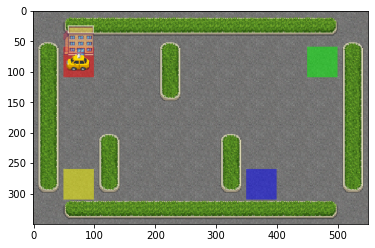

Timestep: 1874
State: 0
Action: 5
Reward: 20


In [ ]:
print_frames(frames)

As it can be seen, the results are not good. The agent takes thousands of timesteps and makes lots of wrong drop offs to deliver just one passenger to the right destination.

This is because we aren't learning from past experience. I initialized a value called num_episodes to run this over and over, but as it can be seen, it will never optimize because the agent has no memory of which action was best for each state.

Next, I plot some graphs to later use them for comparing this random algorithm with the Q-Learning algorithm. I run the algorithm for a large number of episodes and plot the results:


In [ ]:
num_episodes = 2000
rewards_1 = []
timesteps_1 = []
penalties_1 = []

for episode in range(num_episodes):

    penalty, epochs, sum_rewards = 0, 0, 0
    done = False

    while not done:
      action = env.action_space.sample()
      state, reward, done, info = env.step(action)

      if (reward == -10 or reward == -1):
        penalty += 1

      sum_rewards += reward
      epochs += 1

    rewards_1.append(sum_rewards)
    penalties_1.append(penalty)
    timesteps_1.append(epochs)

Plotting the **Average Rewards per Move**:

In [ ]:
Avg_Reward = []
for i in range (len(rewards_1)):
  Avg_Reward.append(rewards_1[i] / timesteps_1[i]) 
Avg_Reward = savgol_filter(Avg_Reward, window_length=11, polyorder=2) 

Text(0.5, 1.0, 'Rewards per Episode')

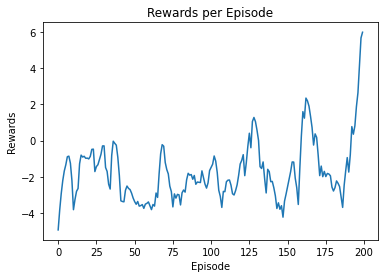

In [ ]:
x = range(200)
y = Avg_Reward[:200]
plt.plot(x,y)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards per Episode')

Plotting the **Average number of penalties per Episode**:

Text(0.5, 1.0, 'Penalties per Episode')

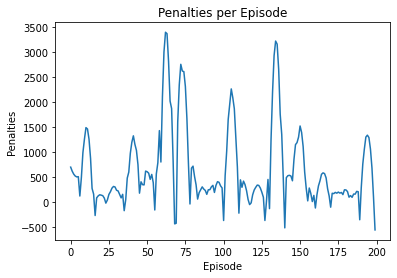

In [ ]:
penalties_1 = savgol_filter(penalties_1, window_length=11, polyorder=2) 
x =  range(200)
y = penalties_1[:200]
plt.plot(x,y)
plt.xlabel('Episode')
plt.ylabel('Penalties')
plt.title('Penalties per Episode')

Plotting the **Average number of timesteps per Trip:**

Text(0.5, 1.0, 'Timesteps per Episode')

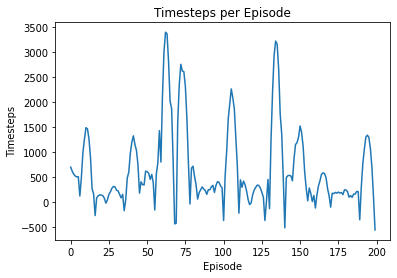

In [ ]:
timesteps_1 = savgol_filter(timesteps_1, window_length=11, polyorder=2) 
x = range(200)
y = timesteps_1[:200]
plt.plot(x,y)
plt.xlabel('Episode')
plt.ylabel('Timesteps')
plt.title('Timesteps per Episode')

In [ ]:
print("Average timesteps per episode:", sum(timesteps_1) / num_episodes)

Average timesteps per episode: 713.5665652680665


As we see from the above graphs, the results don't converge and we don't get an optimum solution.

# **Part B)** with Reinforcement Learning:

Q-learning lets the agent use the environment's rewards to learn the best action to take in a given state. In the Taxi environment, we have the reward table, P, that the agent will learn from. It recieves a reward for taking an action in the current state, then updates a Q-value to remember if that action was beneficial. So, a Q-value for a particular state-action combination is representative of the "quality" of an action taken from that state. 

Q-values are initialized to an arbitrary value and are updated iteratively with the below equation:

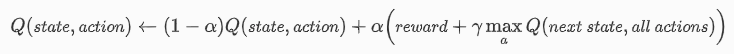

Where alpha is the **learning rate**, and just like in supervised learning settings, is the extent to which our Q-values are being updated in every iteration.

Also, gamma is the **discount factor**, which determines how much importance we want to give to future rewards. A high value for the discount factor (close to 1) captures the long-term effective award, but a discount factor of 0 makes our agent consider only immediate reward.

So in conclusion, we are updating the Q-value of the agent's current state and action by first taking a weight of the **old Q-value**, then adding the **learned value**. The learned value is a combination of the reward for taking the current action in the current state, and the discounted maximum reward from the next state we will be in once we take the current action. This will eventually cause our taxi to consider the route with the **best rewards** put together.

We also use a **Q-table** for storing the values. We have a row for every state (500) and a column for every action (6). It's first initialized to 0, and then values are updated after training.



In [25]:
Q_table = np.zeros([env.observation_space.n, env.action_space.n])

First, the agent decides whether to pick a random action or the previous Q-values, by using the epsilon value and comparing it to an arbitrary value (random.uniform(0,1)). Next, I calculate the maximum Q-value for the actions corresponding to the next_state to update the Q-value.

In [26]:
alpha = 0.5
gamma = 0.7
epsilon = 0.5

epochs_2 = []
penalties_2 = []
rewards_2 = []

env = gym.make("Taxi-v3").env
env.reset()

for i in range(1, 10001):
  state = env.reset()
  penalty, epochs, sum_reward =  0, 0, 0
  done = False
    
  while not done:

    if random.uniform(0, 1) < epsilon:
      action = env.action_space.sample()
    else:
      action = np.argmax(Q_table[state])


    next_state, reward, done, info = env.step(action) 

    old_value = Q_table[state, action]
    next_max = np.max(Q_table[next_state])
    new_value = old_value + alpha * (reward + gamma * next_max - old_value)
    Q_table [state, action] = new_value
    state = next_state

    if (reward == -10 or reward == -1):
      penalty += 1
    sum_reward += reward
    epochs += 1

  epochs_2.append(epochs)
  rewards_2.append(sum_reward)
  penalties_2.append(penalty)

/usr/local/lib/python3.8/dist-packages/gym/core.py:317: DeprecationWarning: WARN: Initializing wrapper in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(
/usr/local/lib/python3.8/dist-packages/gym/wrappers/step_api_compatibility.py:39: DeprecationWarning: WARN: Initializing environment in old step API which returns one bool instead of two. It is recommended to set `new_step_api=True` to use new step API. This will be the default behaviour in future.
  deprecation(


As we saw, now we have implemented a Q-table over 100,000 episodes. 

Now, we visualize the game environment. As we can see, the algorithm is much faster, and takes only 13 timesteps to reach the goal.

In [27]:
epochs = 0
penalties, reward = 0, 0
frames = []
state = env.reset()
done = False
while not done:
  action = np.argmax(Q_table[state])
  state, reward, done, info = env.step(action)
  if (reward == -10 or reward == -1):
    penalties += 1
  frames.append({
    'frame': env.render(mode = 'rgb_array'),
    'state': state,
    'action': action,
    'reward': reward})
  epochs += 1

/usr/local/lib/python3.8/dist-packages/gym/core.py:43: DeprecationWarning: WARN: The argument mode in render method is deprecated; use render_mode during environment initialization instead.
See here for more information: https://www.gymlibrary.ml/content/api/
  deprecation(


In [28]:
print("Timesteps taken: {}".format(epochs))
print("Penalties incurred: {}".format(penalties))

Timesteps taken: 16
Penalties incurred: 15


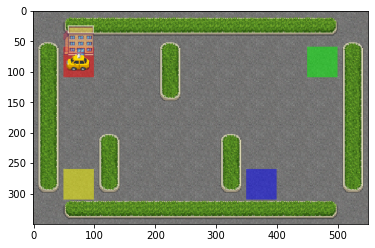

Timestep: 16
State: 0
Action: 5
Reward: 20


In [29]:
print_frames(frames)

Now, we run the code for the same number of episodes and compare the results to the previous algorithm.

Plotting the **Average Rewards per Move**:

In [30]:
Avg_Reward_2 = []
for i in range (len(rewards_2)):
  Avg_Reward_2.append(rewards_2[i] / epochs_2[i])  
Avg_Reward_2 = savgol_filter(Avg_Reward_2, window_length=11, polyorder=2)

Text(0.5, 1.0, 'Rewards per Episode')

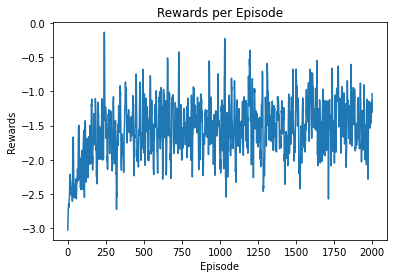

In [39]:
x = range(2000)
y = Avg_Reward_2[:2000]
plt.plot(x,y)
plt.xlabel('Episode')
plt.ylabel('Rewards')
plt.title('Rewards per Episode')

Plotting the **Average number of penalties per Episode**:

Text(0.5, 1.0, 'Penalties per Episode')

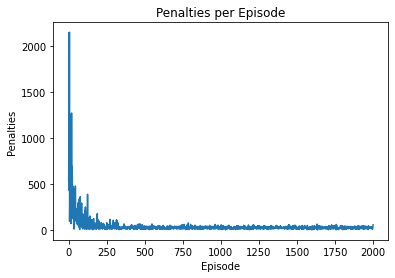

In [38]:
x = range(2000)
y = penalties_2[:2000]
plt.plot(x,y)
plt.xlabel('Episode')
plt.ylabel('Penalties')
plt.title('Penalties per Episode')

Plotting the **Average number of timesteps per Trip:**

Text(0.5, 1.0, 'Timesteps per Episode')

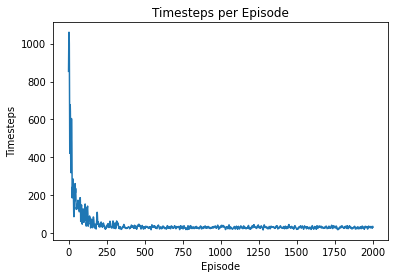

In [40]:
timesteps_2 = savgol_filter(epochs_2, window_length=11, polyorder=2)  
x = range(2000)
y = timesteps_2[:2000]
plt.plot(x,y)
plt.xlabel('Episode')
plt.ylabel('Timesteps')
plt.title('Timesteps per Episode')

As we see, the Q-Learning algorithm is much faster, and the agent's performance improved very well as the penalties and the timesteps decreased, and the results converged pretty well.



For tuning the hyperparameters:

The values of `alpha`, `gamma`, and `epsilon` are usually based on intuition and trial and error.

However, for tuning these hyperparameters, we know that all three should decrease over time because as the agent continues to learn, it actually builds up more resilient priors.

**alpha** should decrease as we continue to gain a larger and larger knowledge base.

Our preference for near-term reward should increase as we move forward, so **gamma** should decrease.

As we develop our strategy, we have less need of exploration and more exploitation to get more utility from our policy, so **epsilon** should decrease.

We can also use **grid search** to select the parameters that would give us the best results. There are also other ways to get better hyperparameter values, like using Genetic Algorithms.

